# Composite California Current CO$_{2}$ Flux EOFs

I discovered some interesting EOFs of CO2 Flux in the CalCS. How do these principal component time series map onto the North Pacific relative to other variables?

Take the PC of e.g. the first EOF, and find each month where it surpasses +1$\sigma$. Then index those months and average across them for a given variable (e.g. SST or SLP) in the NP and map that average.

In [181]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline
import esmtools as et
import cartopy.crs as ccrs
plt.style.use('ocn-clim')
import cmocean.cm as cm
import cartopy.feature as cfeature
import seaborn as sns

### (1) Load in a simulation's PC of CO2 flux

In [183]:
filepath = '/glade/p/work/rbrady/EBUS_BGC_Variability/regional_EOFs/CalCS/FG_ALT_CO2/'
filename = 'FG_ALT_CO2.EOF.192001-201512.nc'
ds = xr.open_dataset(filepath + filename)
# Take the first ensemble member to simplify and the first mode.
ds = ds.sel(ensemble=0, mode=1)

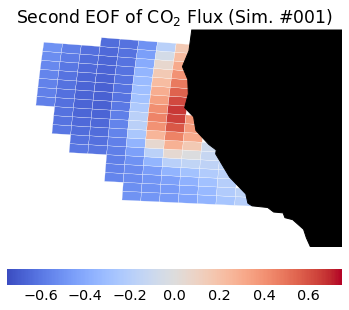

In [184]:
lon=ds.TLONG
lat=ds.TLAT
data=ds.eofs
f, ax = et.vis.make_cartopy(projection=ccrs.PlateCarree(), frameon=False,
                            grid_lines=False, figsize=(6,8))
p = plt.pcolor(lon-0.5, lat, data.to_masked_array(), vmin=-0.75, vmax=0.75,
           cmap="coolwarm", edgecolor='w')
x0,x1,y0,y1 = et.ebus.visual_bounds('CalCS')
ax.set_extent([x0,x1,y0,y1])
cb = plt.colorbar(p, orientation='horizontal', pad=0.05, fraction=0.05)
ax.set_title('Second EOF of CO$_{2}$ Flux (Sim. #001)')
plt.show()

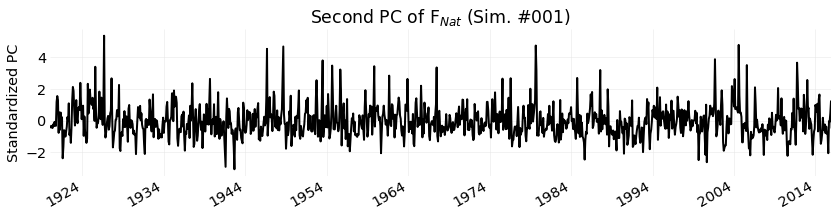

In [186]:
fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot(111)
ds['pc'].plot(linewidth=2, color='k')
ax.set(xlim=['1920', '2015-12'], title='Second PC of F$_{Nat}$ (Sim. #001)',
       ylabel='Standardized PC', xlabel='')
plt.show()

### (2) Define the "extreme" positive and negative events via $\sigma$

In [187]:
# Start out with 2 sigma to make it conservative.
two_sigma = ds['pc'].std()*2

# Filter by events that are larger than 2 standard deviations, and pull out the
# time indices of these events. There might be an easier way to do neutral...
pos_events_index = ds['pc'].where((ds['pc'] >= two_sigma), drop=True)['time']
neg_events_index = ds['pc'].where((ds['pc'] <= two_sigma*-1),drop=True)['time']
neu_events_index = ds['pc'].where((ds['pc'] < two_sigma ) & (ds['pc'] > two_sigma*-1), 
                                  drop=True)['time']

# Just the events themselves from this time series.
pos_events = ds['pc'].sel(time=pos_events_index)
neg_events = ds['pc'].sel(time=neg_events_index)

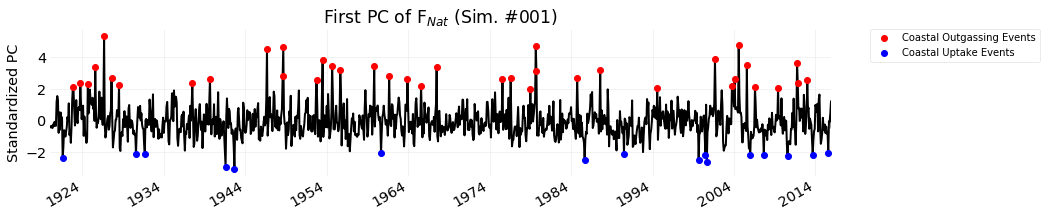

In [189]:
# Plot to show the positive and negative events.
fig = plt.figure(figsize=(14,3))
ax = fig.add_subplot(111)
ds['pc'].plot(linewidth=2, color='k', label='')
pos_events.plot.line('or', label='Coastal Outgassing Events')
neg_events.plot.line('ob', label='Coastal Uptake Events')
ax.set(xlim=['1920', '2015-12'], title='First PC of F$_{Nat}$ (Sim. #001)',
       ylabel='Standardized PC', xlabel='')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### (3) Load in some other variable for the NP for this simulation.

** NOTE ** : Do I need to use residuals? Starting with just mean state

** NOTE ** : For scripted code, maybe should use NCOs to reduce to 1920-2015, and then concatenate into one big string and detect events from there.

In [215]:
VAR = 'U10'
residual = True # Should we use simply the residuals?

# Load in variable
if residual:
    if (VAR == 'PSL') or (VAR == 'U10') or (VAR == 'curl'):
        filepath = ('/glade/scratch/rbrady/EBUS_BGC_Variability/global_residuals/' + 
                    VAR + '/')
        filename = 'residual.' + VAR + '.001.192001-201512.nc'
        ds = xr.open_dataset(filepath + filename)
        ds['time'] = pd.date_range('1920-01', '2016-01', freq='M')
    else:
        filepath = ('/glade/scratch/rbrady/EBUS_BGC_Variability/global_residuals/' + 
                    VAR + '/remapped/')
        filename = 'remapped.' + VAR + '.001.192001-201512.nc'
        ds = xr.open_dataset(filepath + filename, decode_times=False)
        ds = ds.squeeze()
        ds['time'] = pd.date_range('1920-01', '2016-01', freq='M')
else:
    if (VAR == 'PSL') or (VAR == 'U10') or (VAR == 'curl'):
        filepath = '/glade/scratch/rbrady/EBUS_BGC_Variability/' + VAR + '_monthly/'
        filename = VAR + '.001.192001-210012.nc'
        ds = xr.open_dataset(filepath + filename)
    # For now, using my remapped variables. Later can use native grids.
    else:
        filepath = ('/glade/scratch/rbrady/EBUS_BGC_Variability/' + VAR + '_monthly/' +
                    'remapped/')
        filename = 'remapped.' + VAR + '.001.192001-210012.nc'
        ds = xr.open_dataset(filepath + filename, decode_times=False)
        ds = ds.squeeze()
ds = ds[VAR]

if VAR == 'PSL':
    # Convert to hPa
    ds = ds / 100

# Filter from 1920-2015
if not residual:
    ds['time'] = pd.date_range('1920-01', '2101-01', freq='M')
    ds = ds.sel(time=slice('1920-01','2015-12'))

# Pick out the North Pacific.
ds = ds.sel(lat=slice(-10,60), lon=slice(145,260))

In [216]:
# Composite over all the positive events.
ds_pos = ds.sel(time=pos_events_index).mean(dim='time')
ds_neg = ds.sel(time=neg_events_index).mean(dim='time')
ds_neu = ds.sel(time=neu_events_index).mean(dim='time')

# When do these events happen?

In [217]:
# Create a DataFrame with month and number of instances in that month.
labels = ['January', 'February', 'March', 'April',
          'May', 'June', 'July', 'August', 'September',
          'October', 'November', 'December']
df = neg_events_index['time.month'].to_dataframe()
count = df.groupby('month').size()

# DataFrame for plotting
df_plot = pd.DataFrame(index=np.arange(1,13,1), columns=['freq', 'label'])
df_plot['freq'] = (count/count.sum())*100
df_plot['label'] = labels

(0, 51)

/glade/u/home/rbrady/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


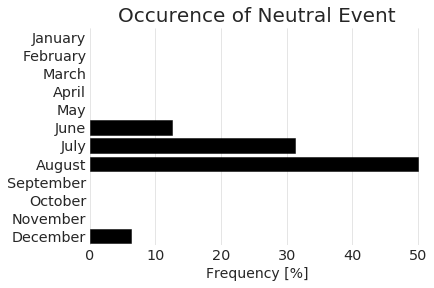

In [218]:
sns.set_style('whitegrid')
f, ax = plt.subplots(ncols=1,nrows=1)
sns.barplot(x="freq", y="label", data=df_plot, color='k',
            orient='h')
sns.despine(left=True, bottom=True)

ax.set_xlabel('Frequency [%]', fontsize=14)
ax.set_ylabel('')
ax.set_title('Occurence of Neutral Event', fontsize=20)
ax.set_xlim([0, 51])

# Visualize

In [219]:
def pcolor_subplot(ax, ds):
#    p = ds.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
#                         levels=np.arange(5, 31, 2), cmap=cm.thermal)
#    p = ds.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
#                         levels=np.arange(1008, 1031, 2), cmap=cm.dense)
    p = ds.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), add_colorbar=False,
                         levels=np.linspace(-2,2,11), cmap=cm.thermal)

    ax.add_feature(cfeature.LAND, facecolor='k')
    ax.outline_patch.set_edgecolor('w')
    x0,x1,y0,y1 = et.ebus.visual_bounds('CalCS', std_lon=True)
    et.vis.add_box(ax, x0, x1, y0, y1, edgecolor='w', facecolor='w',
                   alpha=0.25)
    return p

/glade/u/home/rbrady/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


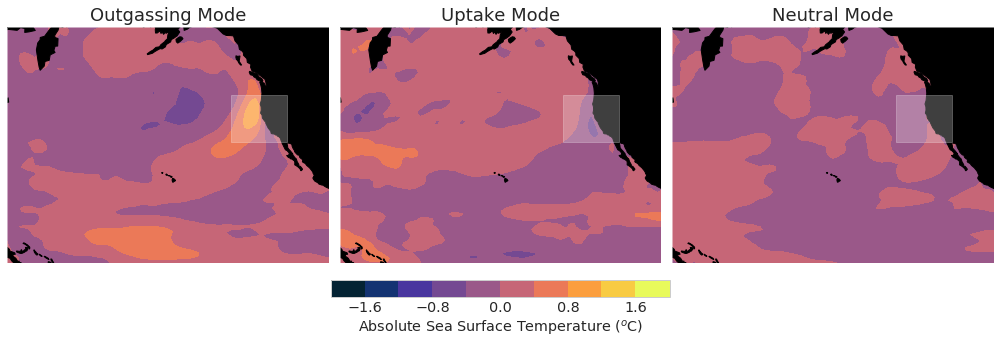

In [220]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14,5), 
                         subplot_kw=dict(projection=ccrs.Mercator(central_longitude=180)))
# OUTGASSING MODE
pcolor_subplot(axes[0], ds_pos)
axes[0].set_title('Outgassing Mode', fontsize=18)

# UPTAKE MODE
p = pcolor_subplot(axes[1], ds_neg)
axes[1].set_title('Uptake Mode', fontsize=18)

# NEUTRAL MODE
p = pcolor_subplot(axes[2], ds_neu)
axes[2].set_title('Neutral Mode', fontsize=18)

# COLORBA
fig.tight_layout()
cb = fig.colorbar(p, ax=axes.ravel().tolist(), orientation='horizontal',
             fraction=0.05, pad=0.05)
cb.set_label('Absolute Sea Surface Temperature ($^{o}$C)')